# Masking POC
### Clipping the current forest loss layer to non-managed forests

We need to ensure, as far as possible, that the deforestation areas (and associated emissions) are calculated for natural forest loss, not for plantations/managed forests. This is a POC to cuantify the impact of this masking.

We are going to use the following data:

* [Matt Hansen (2013)](https://www.science.org/doi/10.1126/science.1244693) forest loss layer. [data source](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/download.html) 
    * values >0 represent deforested year within that pixel
    

*  [Lesiv (2022)](https://www.nature.com/articles/s41597-022-01332-3) forest management layer to remove deforestation in managed locations. [data source](https://zenodo.org/record/5879022)
    * 11 – Naturally regenerating forest without any signs of management, including primary forests, 
    * 20 – Naturally regenerating forest with signs of management, e.g., logging, clear cuts, 
    * 31– Planted forest; 
    * 32 – Plantation forests (rotation time up to 15 years), 
    * 40 – Oil palm plantations, 
    * 53 – Agroforestry



We are going to do the following:

1. Clip the Lesiv forest management layer to the extent of the Hansen forest loss layer.
2. resample the lesiv layer to match the resolution of the Hansen layer
3. Mask the Hansen forest loss layer to remove deforestation in managed locations (masking everything above class value >11 )
4. Compare the results with the original Hansen forest loss layer within some areas of interest

Should we perform a downsampling of the Hansen layer to match the resolution of the Lesiv layer?  
The Hansen layer is at 30m resolution, while the Lesiv layer is at 100m resolution. Usually we should downsample the Hansen layer to match the resolution of the Lesiv layer, but in this case as what we intend to do is to mask the Hansen layer, we can keep the Hansen layer at 30m resolution and upsample the Lesiv layer to match the resolution of the Hansen layer.

In [1]:
# insert code here
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio import Affine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import pandas as pd
import rasterstats
import shapely
import math

from dataclasses import dataclass
from typing import List, Optional

### Download the data from the source

In [2]:
# download one tile of forest loss
!wget https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif -O ./Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif

--2023-01-31 09:26:10--  https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.178.176, 216.58.215.176, 216.58.215.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.178.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95119791 (91M) [image/tiff]
Saving to: ‘./Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif’

./Hansen_GFC-2021-v 100%[===================>]  90.71M  77.8MB/s    in 1.2s    

2023-01-31 09:26:12 (77.8 MB/s) - ‘./Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif’ saved [95119791/95119791]



In [3]:
# download the raster of managed forest
!wget https://zenodo.org/record/5879022/files/FML_v3-2_with-colorbar.tif?download=1 -O ./FML_v3-2_with-colorbar.tif

--2023-01-31 09:38:32--  https://zenodo.org/record/5879022/files/FML_v3-2_with-colorbar.tif?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1605739600 (1.5G) [image/tiff]
Saving to: ‘./FML_v3-2_with-colorbar.tif’

./FML_v3-2_with-col 100%[===================>]   1.50G  3.83MB/s    in 12m 54s 

2023-01-31 09:51:27 (1.98 MB/s) - ‘./FML_v3-2_with-colorbar.tif’ saved [1605739600/1605739600]



In [4]:
# unzip the aoi shapefile
!unzip ./download.zip

Archive:  ./download.zip
   creating: layers/
 extracting: layers/POLYGON.shp      
 extracting: layers/POLYGON.shx      
 extracting: layers/POLYGON.dbf      
 extracting: layers/POLYGON.prj      


In [18]:
# TODO: clean up function and classes

In [2]:
@dataclass
class RasterParams:
    data: np.ndarray
    transform: Affine
    crs: str

In [3]:
def plot_raster(raster, title, cmap='viridis'):
    """Plot a raster using matplotlib"""
    fig, ax = plt.subplots(figsize=(10, 10))
    #show(raster, ax=ax, cmap=cmap, title=title)
    ax.imshow(raster, cmap=cmap)
    ax.set_title(title)
    plt.show()

def plot_multi_raster(rasters, titles, extent_data = None, cmap='viridis'):
    """Plot multiple rasters using matplotlib"""
    fig, axes = plt.subplots(1, len(rasters), figsize=(20, 20))
    for i, (raster, title) in enumerate(zip(rasters, titles)):
        pcm = axes[i].imshow(raster, cmap=cmap, extent=extent_data)
        cax = axes[i].inset_axes([1.04, 0, 0.02, 1])
        axes[i].set_title(title, fontweight='bold')
        fig.colorbar(pcm, ax=axes[i], shrink=0.6, cax=cax)
    plt.show()

def plot_multi_raster_with_gdf(rasters: List[RasterParams], titles, gdf, extent_data = None, cmap='viridis'):
    """Plot multiple rasters using matplotlib"""
    fig, axes = plt.subplots(1, len(rasters), figsize=(20, 20))
    for i, (raster, title) in enumerate(zip(rasters, titles)):
        pcm = axes[i].imshow(raster.data, cmap=cmap, extent=plotting_extent(raster.data, raster.transform))
        cax = axes[i].inset_axes([1.04, 0, 0.02, 1])
        axes[i].set_title(title, fontweight='bold')
        fig.colorbar(pcm, ax=axes[i], shrink=0.6, cax=cax)
        gdf.plot(ax=axes[i], facecolor='none', edgecolor='red', linewidth=2)
    plt.show()

def plot_raster_histogram(raster, title, bins=100):
    """Plot a histogram of a raster"""
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(raster.flatten(), bins=bins)
    ax.set_title(title, fontweight='bold')
    plt.show()

def plot_multi_raster_histogram(rasters, titles, bins=100):
    """Plot multiple histograms of a raster"""
    fig, axes = plt.subplots(1, len(rasters), figsize=(20, 5) )
    for i, (raster, title) in enumerate(zip(rasters, titles)):
        axes[i].hist(raster.flatten(), bins=bins)
        axes[i].set_title(title, fontweight='bold')
        
    plt.show()

def year_formatter(x, pos):
    """Format the x axis of a plot to show years"""
    return f'{int(x+2000)}'

def plot_multi_loss_bar(rasters, titles, formater=year_formatter):
    """Plot multiple histograms of a raster"""
    fig, axes = plt.subplots(1, len(rasters), figsize=(20, 5),sharey=True)
    for i, (raster, title) in enumerate(zip(rasters, titles)):
        data = np.unique(raster.flatten(), return_counts=True)
        axes[i].bar(*data)
        axes[i].xaxis.set_major_formatter(formater)
        axes[i].xaxis.set_major_locator(ticker.AutoLocator())
        axes[i].set_title(title, fontweight='bold')
    plt.show()

def bbox_to_array(bbox):
    """Convert a bounding box to a numpy array"""
    return [bbox.left, bbox.bottom, bbox.right, bbox.top]



In [4]:
def resample_raster(dataset, scale, window: rasterio.windows.Window=None, band=1, masked=True, resampling=rasterio.enums.Resampling.nearest):
    """ Resample a raster
        multiply the pixel size by the scale factor
        divide the dimensions by the scale factor
        i.e
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 0.5,
        the resampled raster would have an output pixel size of 125m and dimensions of (2048, 2048)
        returns a DatasetReader instance from either a filesystem raster or MemoryFile (if out_path is None)

    Args:
        dataset (rasterio.DatasetReader): rasterio dataset
        scale (float): scale factor
        window (rasterio.windows.Window, optional): rasterio window. Defaults to None.
        band (int, optional): band to read. Defaults to 1.
        masked (bool, optional): mask nodata values. Defaults to True.
        resampling (rasterio.enums.Resampling, optional): resampling method. Defaults to rasterio.enums.Resampling.nearest.

    Returns:
        [type]: [description]
    """
    # rescale the metadata
    # scale image transform
    t = dataset.transform
    transform = t * t.scale((1/scale), (1/scale))
    height = math.ceil((window.height if window else dataset.height) * scale)
    width = math.ceil((window.width if window else dataset.width) * scale)

    profile = dataset.profile.copy()
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = dataset.read(
            band, window=window, masked=masked,
            out_shape=(dataset.count, height, width),
            resampling=resampling,
        )

    return data, profile

def resample_array(data: np.ndarray, profile, scale, band=1, masked=True, resampling=rasterio.enums.Resampling.nearest):
    """ Resample a raster
        multiply the pixel size by the scale factor
        divide the dimensions by the scale factor
        i.e
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 0.5,
        the resampled raster would have an output pixel size of 125m and dimensions of (2048, 2048)
        returns a DatasetReader instance from either a filesystem raster or MemoryFile (if out_path is None)
    """
    # rescale the metadata
    # scale image transform
    t = profile.get('transform')
    transform = t * t.scale((1/scale), (1/scale))
    print(transform)
    height = int(profile.get('height') * scale)
    width = int(profile.get('width') * scale)
    print(height, width)
    print(t.scale((scale), (scale)))
    crs = profile.get('crs')
    no_data = profile.get('nodata')

    new_profile = profile.copy()

    new_data, new_affine = reproject( source=data,
                                destination=np.zeros((band, height, width), dtype=data.dtype),
                                src_transform=t,
                                src_crs=crs,
                                dst_crs=crs,
                                dst_nodata=no_data,
                                dst_transform=transform,
                                resampling=resampling)
    
    new_profile.update({"driver": "GTiff",
                 "height": height,
                 "width": width,
                 "transform": new_affine})

    return new_data[band-1], new_profile

def corregister_raster(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height
        })

        # reproject the data
        with rasterio.open(outfile, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src_transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

def save_raster(data, profile, out_path):
    """Save a raster to disk

    Args:
        data (np.ndarray): raster data
        profile (dict): rasterio profile
        out_path (str): output path
    """
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(data, 1)

In [5]:
# Read the forest loss file
loss_data = rasterio.open('./Hansen_GFC-2021-v1.9_lossyear_00N_060W.tif', "r+")
manage_data = rasterio.open('./FML_v3-2_with-colorbar.tif', "r+")

# Get the bounding box of the loss raster as is the smallest one.
bbox_loss = bbox_to_array(loss_data.bounds)
polygon = [shapely.geometry.box(*bbox_loss, ccw=True)]

# Read the shapefile and clip it with the raster bounding box
aois = gpd.read_file('./layers/POLYGON.shp').clip(polygon[0])

# Get the coordinates of the shapefile
coords = aois.bounds

# # crop the raster to the intersection
# raster_crop = loss_data.read(1, window=loss_data.window(*coords.values[0]), masked=True)

# # mask the loss raster with the management raster
# mask_orig = manage_data.read(1, window=manage_data.window(*coords.values[0]), masked=True)

(8273, 17359) (2086, 4375)


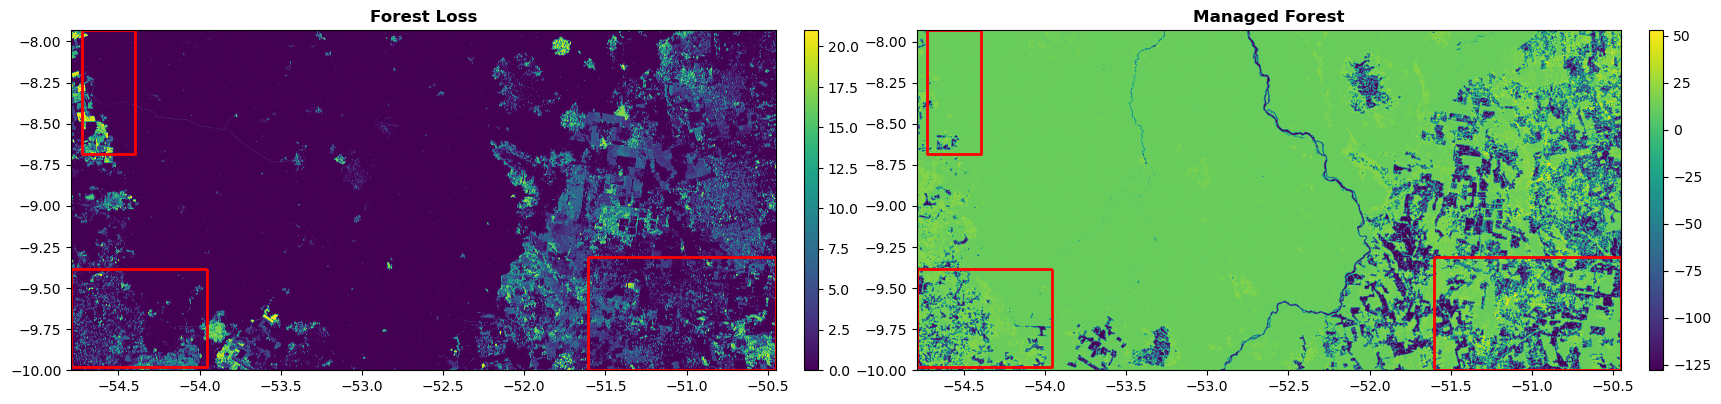

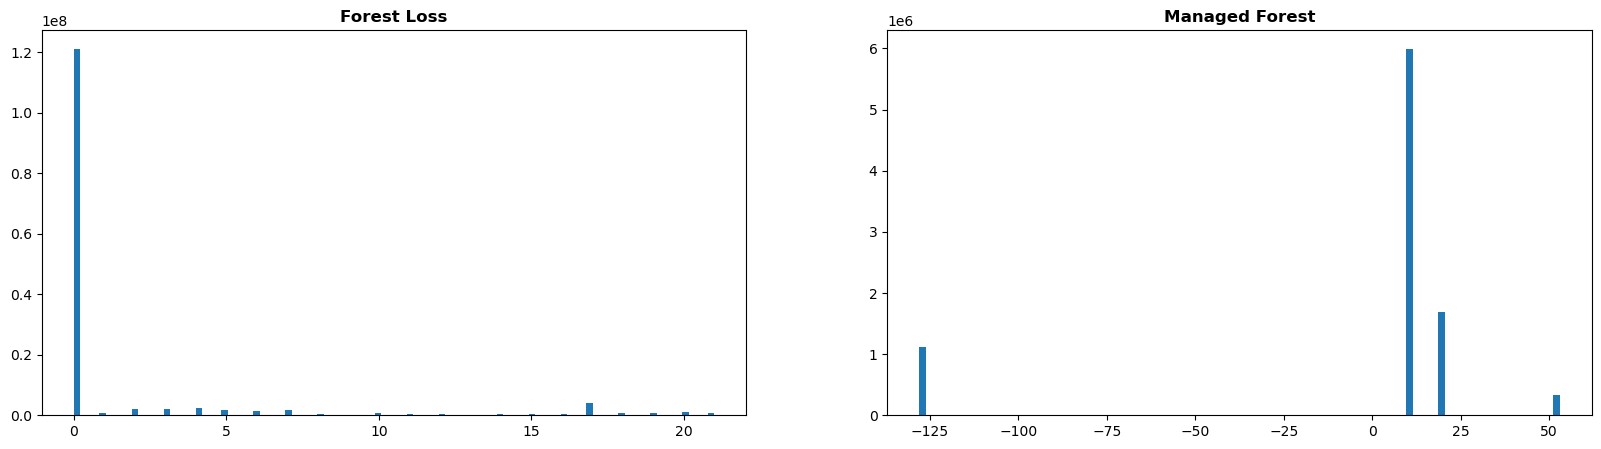

In [7]:
# lets first plot the data focus on the areas of interest
test_loss, affine_loss = mask(loss_data, aois.envelope, indexes=1, crop=True, all_touched=True, nodata=0)
test_mask, affine_mask = mask(manage_data, aois.envelope, indexes=1, crop=True, all_touched=True, nodata=-128)
print(test_loss.shape, test_mask.shape)
plot_multi_raster_with_gdf([
                            RasterParams(test_loss, affine_loss, loss_data.crs), 
                            RasterParams(test_mask,affine_mask, loss_data.crs)
                            ],
                            ['Forest Loss', 'Managed Forest'], 
                            aois)
plot_multi_raster_histogram([test_loss, test_mask], ['Forest Loss', 'Managed Forest'])

In [8]:
# we will need upsampling first the managed forest raster to the same resolution as the loss raster
mask_meta = manage_data.meta.copy()
mask_meta.update({"driver": "GTiff",
                 "height": test_mask.shape[0],
                 "width": test_mask.shape[1],
                 "transform": affine_mask})
# get the resolution of the loss raster
loss_res = loss_data.res
# get the resolution of the managed forest raster
manage_res = manage_data.res
# calculate the upsampling factor
upscale_factor_x = manage_res[0]/loss_res[0]
upscale_factor_y = manage_res[1]/loss_res[1]
mask_window = manage_data.window(*coords.values[0])

In [9]:
# resample the managed forest raster
mask_resampled, mask_profile = resample_raster(manage_data, upscale_factor_x, window=mask_window, masked=True)

(8273, 17359) (8273, 17359)


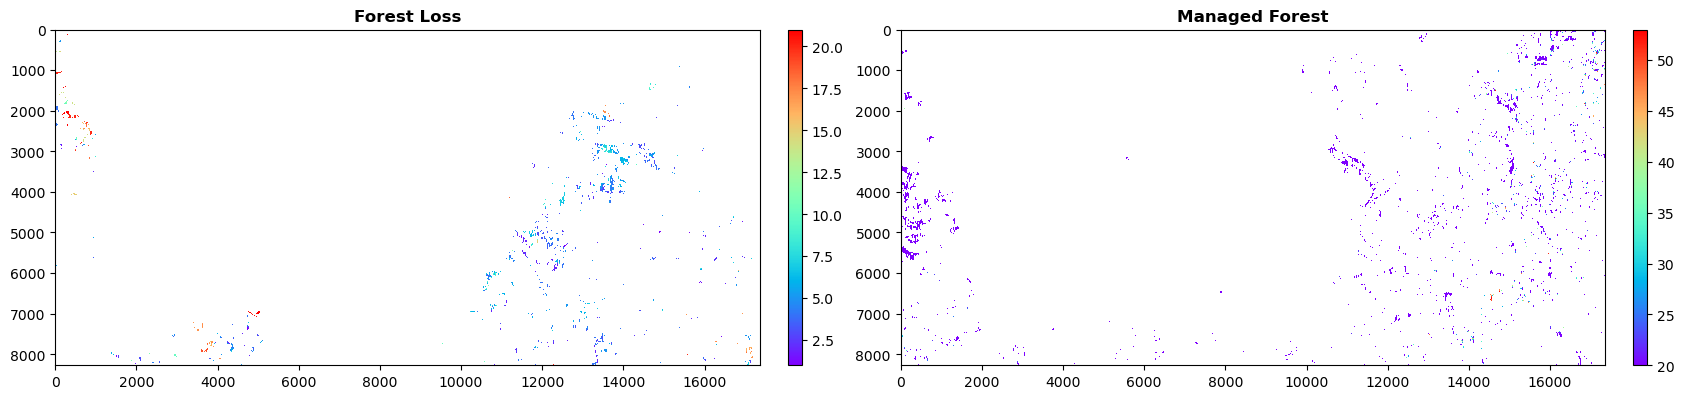

In [10]:
print(test_loss.shape, mask_resampled.shape)
plot_multi_raster([np.ma.masked_where(test_loss== 0, test_loss, copy=True), np.ma.masked_where(mask_resampled < 12, mask_resampled, copy=True)],['Forest Loss', 'Managed Forest'], cmap='rainbow')

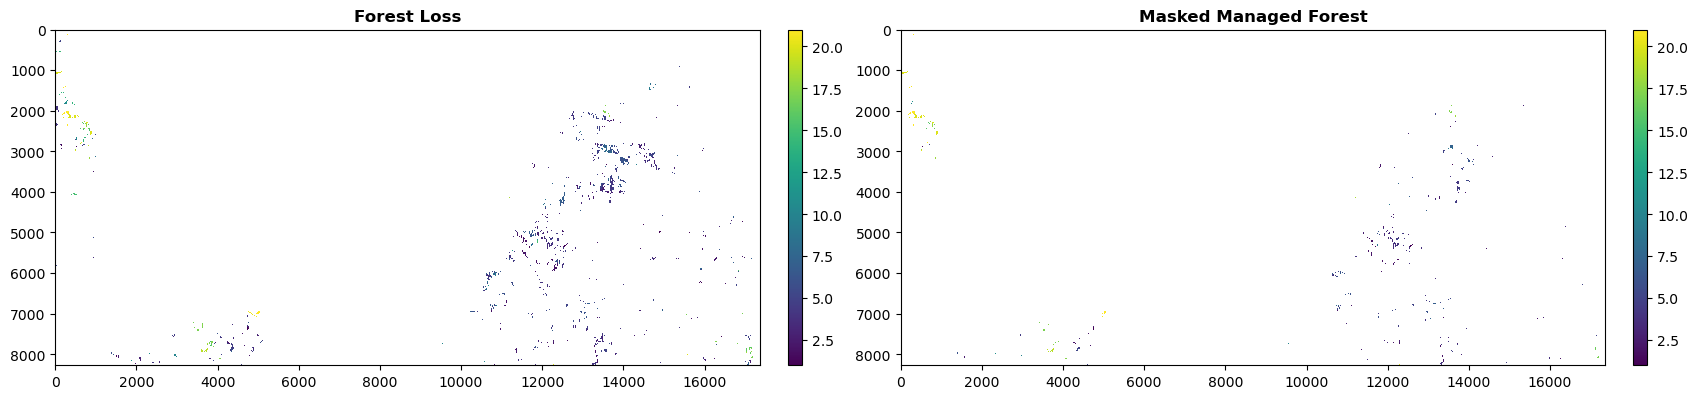

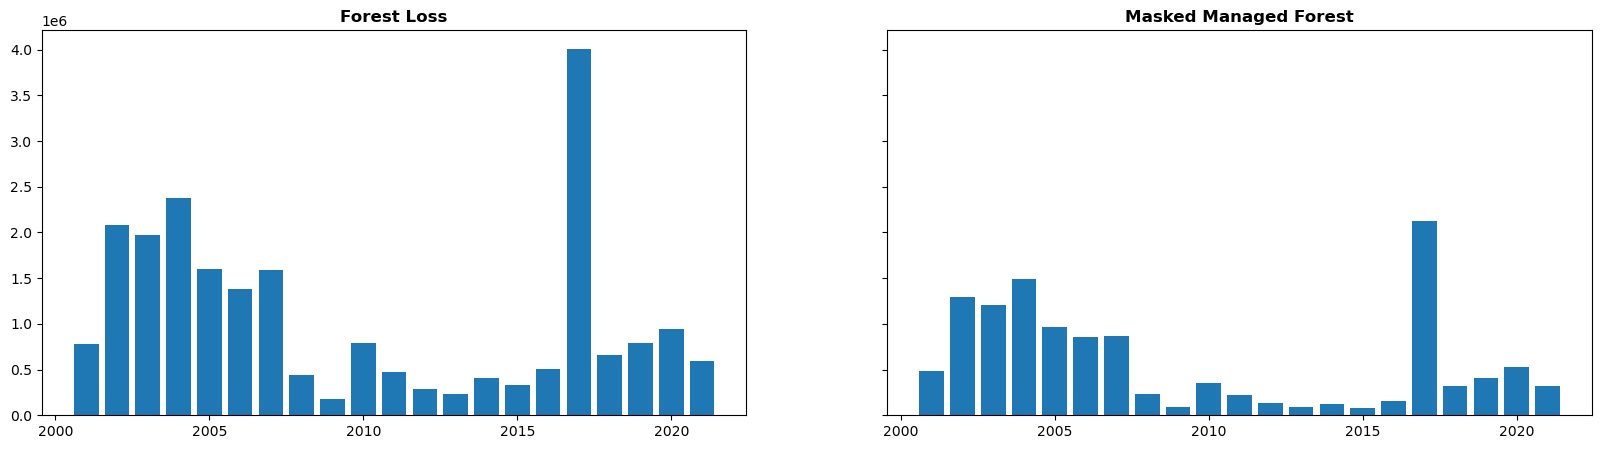

In [11]:
# mask the loss raster with the upsampled management raster
forest_loss = np.ma.masked_where(test_loss == 0, test_loss, copy=True)
masked_loss = np.ma.masked_where(mask_resampled > 11, forest_loss, copy=True)

plot_multi_raster([forest_loss, masked_loss],['Forest Loss', 'Masked Managed Forest'])
plot_multi_loss_bar([forest_loss.compressed(), masked_loss.compressed()], ['Forest Loss', 'Masked Managed Forest'])

let's also open this in Qgis to check the data, how this will also be affected in a more visual way.

In [12]:
profile_loss = loss_data.profile
profile_loss.update({"driver": "GTiff",
                    "height": masked_loss.shape[0],
                    "width": masked_loss.shape[1],
                    "transform": affine_loss})
# TODO: the transform is not correct in the mask profile (to be review why) so we need to update it
mask_profile.update({"driver": "GTiff",
                     "transform": affine_loss})

save_raster(masked_loss, profile_loss, './masked_loss.tif')
save_raster(forest_loss, profile_loss, './forest_loss.tif')
save_raster(mask_resampled, mask_profile, './mask_resampled.tif')

In [13]:
profile_loss

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 17359, 'height': 8273, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -54.79025,
       0.0, -0.00025, -7.93175), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [14]:
mask_profile

{'driver': 'GTiff', 'dtype': 'int8', 'nodata': -126.0, 'width': 17359, 'height': 8273, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -54.79025,
       0.0, -0.00025, -7.93175), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [15]:
reduction_in_deforested = round((len(forest_loss.compressed())- len(masked_loss.compressed()))/len(forest_loss.compressed()),3)*100
print(f'The reduction in deforestation is {reduction_in_deforested}%')

The reduction in deforestation is 44.9%


In [20]:
aois = aois.explode(index_parts=True).reset_index(drop=True)

In [17]:

loss_aois = rasterstats.zonal_stats(aois, forest_loss.filled(0), affine=affine_loss, stats=['count'], nodata=0)
loss_aois_masked = rasterstats.zonal_stats(aois, masked_loss.filled(0), affine=affine_loss, stats=['count'], nodata=0)

areas =[]
for data_loss_data, data_loss_masked in zip(loss_aois, loss_aois_masked):
    data_loss = {}
    data_loss['difference'] = data_loss_data['count'] - data_loss_masked['count']
    data_loss['reduction'] = round((data_loss['difference']/data_loss_data['count'])*100,2)
    areas.append(data_loss)

pd.DataFrame(areas).describe()

,difference,reduction
count,3.000000e+00,3.000000
mean,9.623780e+05,45.693333
std,8.199852e+05,10.141057
min,1.725380e+05,35.290000
25%,5.388150e+05,40.765000
50%,9.050920e+05,46.240000
75%,1.357298e+06,50.895000
max,1.809504e+06,55.550000


So we can see with the above results that masking reduces the deforestation mesured by the Hansen layer by an average of 45% in the areas of interest.  
This will have a significant impact on the risk of deforestation and associated emissions calculated by the model within landgriffon.